In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy.optimize as opt 

# 5.0 - What is data Assimilation about?

- I'm going to describe this in terms of weather forecasting, but the ideas are actually much more general than this. 
- Imagine that you want to make a weather forecast. In order to start the model we need to put in some initial conditions. We would like to get these initial conditions to be as close to the observations as possible in order to have a good forecast.
- The observations you want to use have a couple of problems:
  - The spatial distribution of observations won't match the grid points of the model 
  - The temporal distribution of won't be at the time you want to start the forecast from
  - The observations will have some error in them that means we might not want to use them directly 
- Data Assimilation tries to handle these problems by blending the output of a model and the observations in a way that accounts for the errors and variability in both. In the context of weather forecasting this is very useful, because you can start your model and generate an initial background forecast, then rerun the model over the assimilation window, but you use the observations available in that window in order to correct the model. The new version of the model is called the Analysis. Hopefully, this analysis model matches the truth better than the observations or background do on their own, since it is using information from both
  - It's important to note that if the observations were perfect and at the right times and places there would be no reason to do this, but this will never be the case and so data assimilation is almost always necessary.
  - I've tried to draw this in the figure below: 

<img src="../images/DASchematic.png">

  
## Brief comparison of Data Assimilation schemes

| Data Assimilation Scheme | Forecast Model  | Assimilation | Comments |
| --- | --- | ---- | ---- |
| Optimal Interpolation    |  Standard   |  Assimilation update happens at each observation, Constant Covariances    |   Each assimilation happens independently  |
| Linear Kalman Filter    |   Linearized  |  Assimilation update happens at each observation, Mean and Covariances computed analytically     |  Practical Applications needs a linearized model    |
| Ensemble Kalman Filter    |  Standard Ensemble    |  Assimilation update happens at each observation, Means and Covariances come from Ensemble     |   Many variants exist    |
| 4D Variational Analysis    |  Standard    |  All data points in the assimilation window used, Constant Covariances     |  Practical Applications requires a separate "Adjoint Model" |

## The examples in this section

- After each section I'm going to show an example using a 1DOU process, similar to what you are going to do in the labs. 
- The idea is that we are going to do the following steps:
    1. Create a single run of the 1DOU process, call this Xtrue
    2. Sample Xtrue and add noise representing observational uncertainties to generate a set of observations called Zobs
    3. for each Data Assimilation scheme try to estimate Xtrue using Zobs 
- Below we're going to do steps 1 and 2, and then repeat step 3 for each data assimilation scheme
- For reference, the dynamic model and observation model are:  $$  \begin{align*}
  x_{k} = x_{k-1} -\frac{dt}{\tau} x_{k-1} + B \sqrt{dt} w_k & \\
  z_k = x_k + R u_k 
  \end{align*} $$ Where $w_k$ and $u_k$ are independent Guassian random variables with mean 0 and variance 1.

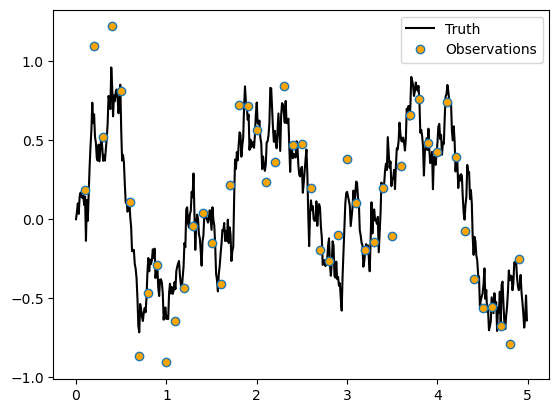

In [2]:
# model parameters
tau = 1
B = 1

dt = 0.01 # time step 
T=5 # how long the model runs for 
t = np.arange(0.0, T, dt)
M = len(t)

# this function steps forward an ensemble forecast 
def stepEnsemble(X):
#    dxdt = (np.roll(X,1,axis=0)-np.roll(X,-2,axis=0))*np.roll(X,-1,axis=0) - X + F
    dx = -X/tau * dt + B *np.sqrt(dt) * np.random.randn(np.shape(X)[0])
    return X + dx

# this generates a "truth" that we are later going to try to estimate 
Xe = np.zeros([1,M])
for i in range(1,M):
    Xe[:,i]=stepEnsemble(Xe[:,i-1])
Xtrue=Xe[0,:]

nobs = 1

# this is going to 
# Noise Strength of the Observations 
R = 0.2
Zobs = Xtrue[:] + R*np.random.randn(nobs,M)

#sampling rate 
tsample = 0.1
nsample = int(tsample//dt)

plt.plot(t,Xtrue,'k',label='Truth')
plt.plot(t[nsample::nsample],Zobs[0][nsample::nsample],
         'o',label='Observations',
         markerfacecolor='orange')
plt.legend()

# 5.1 - Optimal Interpolation

This material is largely from
- DelSole, Timothy, and Michael Tippett. Statistical methods for climate scientists. Cambridge University Press, 2022. Chapter 20 


## 1D optimal interpolation

- Suppose that there is some variable, $x$ that we want to estimate. But, we don't have access to $x$. Instead we only have access to some observations, $z$, which have some noise in them, $$ z=x+\sigma_r u $$ where $w$ is a random normal variable and $\sigma_r$ is a noise strength, and a "background estimate", $x_b$, which have some errors in them: $$x_b=x+\sigma_b w $$, where $v$ is a random normal variable and $\sigma_b$ is a noise strength. 
- We would like to create an optimal estimate of $x$, called the "analysis", $x_a$, which combines our knowledge from both $z$ and $x_b$. 
  - Although this sounds convoluted this situation comes up all the time, usually the background estimate comes from a model, and the analysis is trying to correct the model from the observations.

- Finding $x_a$ is the same as wanting to maximize $$ P(x_a|x_b,z ) $$. This can be expanded using Baye's theorem: $$\begin{align*}
P(x_a|x_b,z) &=& \frac{P(x_a,x_b,z)}{P(x_b,z)} \\ 
&=& \frac{P(z|x_a,x_b)P(x_a|x_b)P(x_b)}{P(z|x_b)P(x_b)} \\ 
&=& \frac{P(z|x_a,x_b)P(x_a|x_b)}{P(z|x_b)} \\ 
\end{align*}$$

- In theory we can just proceed by doing a lot of algebra. You can save a lot of time however if you notice that the final distribution has only have 1 independent variable: $x_a$. This means that any term or factor that doesn't have $x_a$ in it will be a constant, and since we know that our final probability distribution is normalized, these constants will all be equal to the final normalization constant. So its easier to ignore anything without an $x_a$ in it, and then just assume that the distribution is properly normalized at the end.

- so all we need to study is $ P(x_a|x_b,z) \propto  P(z|x_a)P(x_a|x_b) $
  - These all have names:
    - $P(x_a|x_b,z)$ Posterori distribution
    - $P(z|x_a)$ Observation likelyhood
    - $P(x_a|x_b)$ Background distribution

- Now we are going to assume that everything is a Gaussian:
  - $P(z|x_a)=\frac{1}{\sqrt{2\pi\sigma_R^2}}\exp\left(-\frac{\left(x_a-z\right)^2}{2\sigma_R^2}\right)$
  - $P(x_a|x_b)=\frac{1}{\sqrt{2\pi\sigma_R^2}}\exp\left(-\frac{\left(x_a-x_b\right)^2}{2\sigma_B^2}\right)$
  - $\sigma_R^2$ is the variance of the observational noise. 
  - $\sigma_B^2$ is the variance of the background observations, note that it is not the same thing as $b^2$, for the 1D system written above it would be $\frac{1}{2}b^2 a$.

- Combining the two Gaussians is the same as rearranging the following expression $$ \frac{\left(z-x_a\right)^2}{\sigma_R^2} - \frac{\left(x_a-x_b\right)^2}{\sigma_B^2} $$
  - again, the key is to note that we can drop any term that does not have a factor of $x_a$ in it, and we can also add any term that does not include $x_a$, since these will all be combined into the normalization factor at the end. 

$$
\begin{align*}
\frac{\left(z-x_a\right)^2}{\sigma_R^2} - \frac{\left(x_a-x_b\right)^2}{\sigma_B^2} & = & \frac{z^2}{\sigma_R^2} - 2\frac{zx_a}{\sigma_R^2} + \frac{x_a^2}{\sigma_R^2} \\  && - \frac{x_a^2}{\sigma_B^2} + 2\frac{x_ax_b}{\sigma_B^2} - \frac{x_b^2}{\sigma_B^2} \\
& = & \left(x_a^2 - 2x_a \left(\frac{z}{\sigma_B^2}+\frac{x_b}{\sigma_R^2}\right)\left(\frac{1}{\sigma_B^2}+\frac{1}{\sigma_R^2}\right)^{-1} \right) \\ &&  \left(\frac{1}{\sigma_B^2}+\frac{1}{\sigma_R^2}\right) + ... \\
& = & -\left(x_a-\left(\frac{z}{\sigma_B^2}+\frac{x_b}{\sigma_R^2}\right)\left(\frac{1}{\sigma_B^2}+\frac{1}{\sigma_R^2}\right)^{-1} \right)^2 \\ && \left(\frac{1}{\sigma_B^2}+\frac{1}{\sigma_R^2} \right) + ... \\
&=& -\left(\frac{x_a-\mu_a}{\sigma_a}\right)^2 + ... \\ \end{align*}
$$

- where the ... indicate that we have dropped terms not including $x_a$, and we have added and subtracted constant terms not including $x_a$ in order to complete the square.

- $\mu_a = \left(\frac{z}{\sigma_B^2}+\frac{x_b}{\sigma_R^2}\right)\left(\frac{1}{\sigma_B^2}+\frac{1}{\sigma_R^2}\right)^{-1} = z \frac{\sigma_B^2}{\sigma_B^2+\sigma_R^2} + x_b\left(1-\frac{\sigma_B^2}{\sigma_B^2+\sigma_R^2}\right) $
  
- $ \sigma_a^2  =  \left(\frac{1}{\sigma_B^2}+\frac{1}{\sigma_R^2} \right)^{-1}=  \left(1-\frac{\sigma_B^2}{\sigma_R^2+\sigma_B^2} \right)\sigma_B^2 $

- $ \frac{\sigma_B^2}{\sigma_R^2+\sigma_B^2} $ is the relative fraction of the background noise to the total noise. This is sometimes called the "Kalman Gain" of the system, and denoted by $K$. When $K$ is close to 1, $x_a\rightarrow z$, and when $K$ is close to 0, $x_a\rightarrow x_b$. In other words, $K$ determines how much the update from the observations affects the analysis, which is why it's called the gain.

- We can now write the 1D equations in their final form:
$$K =  \frac{\sigma_B^2}{\sigma_R^2+\sigma_B^2}$$
$$\mu_a = K z + (1-K)x_b$$
$$\sigma_a^2 = (1-K)\sigma_b^2$$

- So finally we can use these definitions to write $P(x_a|z,x_b)=\frac{1}{\sqrt{2\pi\sigma_a^2}}\exp\left(-\frac{\left(x_a-\mu_a\right)^2}{2\sigma_a^2}\right)$

- Since distribution is Gaussian, then $\mu_a$ is the best estimate of the state space, and the average error will be something like $\sigma_a$.

## Vector Optimal Interpolation Equations

- Imagine now that we have vector versions of the equations that we started with:

$$ \begin{align*} \vec{z}=&H\vec{x} + R \vec{w}\\
                  \vec{x}_b = & \vec{x} + B \vec{u} 
 \end{align*} $$

- Now we need to define a matrix $\Gamma_r$ which characterizes the uncertainities in the observations, and a matrix $\Gamma_b$ that characterizes the uncertainties in the background estimate. For this relatively simple example it makes sense to define them using: $$ \begin{align*} \Gamma_b=B^TB \\ \Gamma_r=R^TR \end{align*}$$
  - More generally, we will want to define $\Gamma_b$ and $\Gamma_r$ using some knowledge about our model and the observations. This will become a theme later on.

- The major difference between these equations and the last equations is the introduction of the matrix $H$ the observation operator. The idea is that the observations can be written as linear combinations of $x$ instead of being directly taken from $x$
  - For the scalar case $z$ and $x$ had the same size. For the vector case though $x$ and $z$ are no longer required to have the same size any more.
  - If $H=I$ then the observations are taken directly from $x$
  - If the observations and model grid points are at different points then $H$ will be an interpolation matrix 
  - In more complicated cases $H$ will actually be a non-linear function of $x$, e.g. $H(x)$. This happens a lot with satellite observations, for instance $\vec{x}$ could be the temperatures and moistures in an atmospheric column, and $z$ could be a set of observed radiances. Then $H(x)$ would be an radiative transfer model that computes the observed radiances. In real life non-linear $H$ is quite common, but here we're going to restrict ourselves to the linear case.

- We're going to assume that we can solve the analysis distribution as a multvariate normal distribution with $\mathcal{N}\left(\vec{\mu}_a,\Gamma_a\right)$

- We could repeat all the same steps we took in the scalar case for the vector case and get the solutions. This is really tedious though so we will just skip directly to the answer:

$$ \begin{align*} K = & \Gamma_b H^T \left(H\Gamma_bH^T+\Gamma_r\right)^{-1} \\
\vec{\mu}_a = & \vec{\mu}_b + K\left(\vec{z}-H\vec{\mu}_b\right) \\
\Gamma_a= &\left(I-KH\right)\Gamma_b \end{align*} $$

- The comparison to the scalar equations is obvious in the special case when $H=I$:

$$ \begin{align*} K=&\Gamma_b \left(\Gamma_b+\Gamma_r\right)^{-1} \\
\vec{\mu}_a=&\vec{\mu}_b + K\left(\vec{z}-\vec{\mu}_b\right) = K\vec{z}+ \left(I-K\right)\vec{\mu}_b \\
\Gamma_a=&\left(I-K\right)\Gamma_b \end{align*}$$


## Optimal Interpolation Example

- We're going to try and assimilate the observations over the entire window. 
- Essentially we're going to do this:
    1. if no observation at time $k$, just take a step forward normally 
    2. if observations exist at time $k$, then update the model using optimal interpolation with the observation at that data point.
- For optimal interpolation, we're going to use constant $\Gamma_r$ and $\Gamma_b$.

Text(0.5, 1.0, 'Optimal Inteporlation At Observation Points')

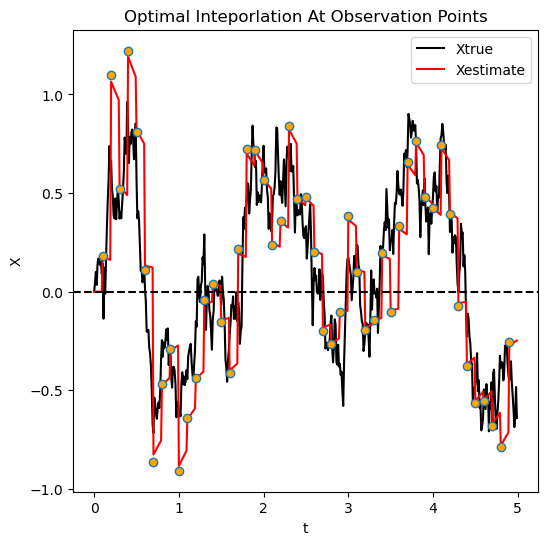

In [3]:
# storage for the state and the covariance matrix 
Xfilter = np.zeros([1,M])

gammaR = np.eye(1)*R**2
gammaB = np.eye(1)*B**2

Hobs=np.eye(1)

# this is a counter to see how often we need to do the update
ns = 0

Am = la.expm(-dt/tau * np.eye(1))

# for optimal interpolation there is only one Kalman Gain Matrix 
# so we just calculate it outside the loop

# part of the kalman gain that we will have to invert
S = np.dot( np.dot(Hobs, gammaB), Hobs.T) + gammaR

# kalman gain matrix     
K = np.dot( gammaB, np.dot( Hobs.T, la.inv(S) ) )

for i in range(1,M):

    # linear forecasts 
    # for the state space the estimate is the ensemble mean, so we can ignore the random term
    Xforecast = np.dot( Am, Xfilter[:,i-1] ) 
        
    #check if we need to do a filter update 
    if ns == nsample-1:
        
        # analysis updates
        Xfilter[:,i] = Xforecast*(1-K) + Zobs[:,i]*K

        # reset the counter         
        ns = 0

    # if no update, put the forecast into the filter         
    else:
        
        Xfilter[:,i] = Xforecast 
        
        ns+=1

fig,axs=plt.subplots(1,1,figsize=(6,6))

axs.plot(t,Xtrue,'k',
    label='Xtrue')
axs.plot(t,Xfilter[0],'r',label='Xestimate')
axs.axhline(0,linestyle='--',color='k')
axs.legend()
axs.set_ylabel('X')
axs.set_xlabel('t')
axs.plot(t[nsample::nsample],Zobs[0][nsample::nsample],
            'o',markerfacecolor='orange',
            label='observations')

plt.title('Optimal Inteporlation At Observation Points')

# 5.2 - The Linear Kalman Filter 

This material is largely from
- DelSole, Timothy, and Michael Tippett. Statistical methods for climate scientists. Cambridge University Press, 2022. Chapter 20 

## Combining Forecast and Analysis steps

- Imagine that we have an OU process that is evolving in time that we have observations of: $$ \begin{align*} d\vec{x} = & \,A \vec{x} dt + B d\vec{W} \\ \vec{z} = & H\vec{x} + R \vec{U} \\ \end{align*} $$

- In the optimal interpolation method we had to estimate $\Gamma_b$ independently of the model. Here we would like to use the model to produce $\Gamma_b$ itself, so that analysis is using more information from the model. We will call this knew estimate the forecast covariance, or $\Gamma^f_k$ to represent the forecast covariance at time step k. 

- If the noise is Gaussian and the system is linear, the Kalman Filter is the optimal way in a least squares sense, i.e. its impossible to make a data assimilation method that will have lower squared errors than a Kalman Filter. Of course, only a tiny subset of actual systems meet these conditions, so more generally its just an approximation.
  
- the idea of the Kalman filter is to estimate $x$ using the observations of $z$. It does this by alternating between forecast steps and analysis steps, where the output of each analysis step is used as the intial condition for the forecast, and the forecast is used as the background distribution for an analysis using optimal interpolation. 
  
- To make our lives slightly easier we can define the "forecast model" by $$\vec{x}^f_{k} = F \vec{x}^f_{k-1} + B\vec{W}_k$$ Where $F=I+Adt$, and we are assuming that $\vec{W}$ is an vector of independent Gaussian random variable. 
  
- In order to do the analysis at time $k+1$ we need the forecast mean, $$\left<\vec{x}^f_k\right>$$ and forecast covariance $$\Gamma^f_k = \left<{\vec{x}^f_k}{\vec{x}^f_k}^T\right>-\left<{\vec{x}^f_k}\right>\left<{\vec{x}^f_k}\right>^T$$

- For the mean we can just take the mean of our forecast model step, and remember that $\left<\vec{w}_k\right>=0$, so that $$\left<\vec{x}^f_{k}\right> = F\left<\vec{x}^f_{k-1}\right> $$
  - Note that this only true for a *linear* model, in general this doesn't work with non-linear forecast models.

- To propagate the covariance matrix forward we calculate $$ \begin{align*} \left<{\vec{x}^f_k}{\vec{x}^f_k}^T\right> = & \left< F {\vec{x}^f_{k-1}} {\vec{x}^f_{k-1}}^T F^T \right> +  \left< F {\vec{x}^f_{k-1}} {\vec{w}_{k-1}}^T B^T \right> \\ & +  \left< B {\vec{w}_{k-1}} {\vec{x}^f_{k-1}}^T F^T \right> +  \left< B {\vec{w}_{k-1}} {\vec{w}_{k-1}}^T B^T \right> \\ = & \left< F {\vec{x}^f_{k-1}} {\vec{x}^f_{k-1}}^T F^T \right> +   \left< B {\vec{w}_{k-1}} {\vec{w}_{k-1}}^T B^T \right>   \end{align*} $$ Where we have dropped the cross terms because $w$ is uncorrelated from $x$ and has zero mean.

- Now we can calculate $\Gamma^f_k$: 
  $$ \begin{align*} \Gamma^f_k = & \left<{\vec{x}^f_k}{\vec{x}^f_k}^T\right>-\left<{\vec{x}^f_k}\right>\left<{\vec{x}^f_k}\right>^T \\
   = & \left< F {\vec{x}^f_{k-1}} {\vec{x}^f_{k-1}}^T F^T \right> +   \left< B {\vec{w}_{k-1}} {\vec{w}_{k-1}}^T B^T \right> - F\left<{\vec{x}^f_{k-1}}\right>\left<{\vec{x}^f_{k-1}}\right>^TF^T  \\
    =& F \Gamma^f_{k-1} F^T + BB^T \\
   \end{align*}$$
  
- We now have all the pieces together to make a Kalman Filter. Assume that we have an analysis that concluded at time $k-1$. To step forwards in time to time $k$: 
  1. Forecast Step: calculate the forecast mean and forecast covariance: $$ \begin{align*} \left<\vec{x}^f_{k}\right> =& F\left<\vec{x}^a_{k-1}\right> \\ \Gamma^f_{k} = & F^T \Gamma^a_{k-1} F + BB^T   \end{align*}$$
  2. Analysis Step: calculate the analysis using the observations and the forecast statistics as the background:
$$ \begin{align*} K = & \Gamma^f_{k} H^T \left(H \Gamma^f_{k} H^T+\Gamma_r\right)^{-1} \\
\left<\vec{x}^a_{k}\right> = & \left<\vec{x}^f_{k}\right> + K\left(\vec{z}-H\left<\vec{x}^f_{k}\right>\right) \\
\Gamma_a= &\left(I-KH\right)\Gamma^f_{k} \end{align*} $$ 

- These alternating forecast and analysis steps are the essence of Kalman Filtering. We use the forecast model to propagate the mean and covariance forward in time until we reach a point where an observation is being taken, and then we use optimal interpolation to update our model using an observation.

- For a non-linear forecast model the Kalman Filter can still be used, but the forecast model has to be linearly truncated first. This results in a method known as the "Extended Kalman Fitler". Most of the time its not very good, and instead some variation on an "Ensemble Kalman Filter" (described in the next section) should be used instead. 

## Interpreting the Covariance Matrix 
- Estimating the covariance was useful because it allows the updates to be more flexible than in the optimal interpolation scheme, if the model is doing well with low variability then it will be weighted more heavily compared to the observations. 
- The covariance matrix has another important meaning. Similar to optimal interpolation, if we assume that the distributions are Gaussian, then the spread of those Gaussians will be given by the variances stored in the covariance matrix. In otherwords, the analysis covariance is quantifying how accurate we expect our filter to be. This is one of the most important things about Kalman filtering, they estimate their own errors. 

## Linear Kalman Filtering Example
- This example is similar to the OI example, but instead of having a constant Kalman update matrix the matrix will have to be recalculated at each observation point using the forecast covariance matrix. 
- Since the model we are using is already linear there is no need to linearize it. In general though it would need to be linearized first.

Text(0.5, 0.98, 'Linear Kalman Filter')

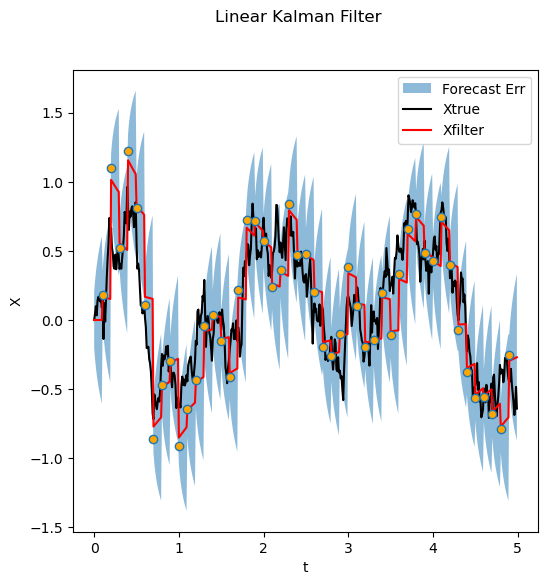

In [4]:
# storage for the state and the cocvariance matrix 
Xfilter = np.zeros([1,M])

Pfilter = np.zeros([1,1,M])
gammaR = np.eye(1)*R**2
Pfilter[:,:,0] = gammaR

Hobs=np.eye(1)

# this is a counter to see how often we need to do the update
ns = 0

Am = la.expm(-dt/tau * np.eye(1))

for i in range(1,M):

    # linear forecasts 
    # for the state space the estimate is the ensemble mean, so we can ignore the random term
    Xforecast = np.dot( Am, Xfilter[:,i-1] ) 
    Pforecast = np.dot( Am, np.dot(Pfilter[:,:,i-1], Am.T) ) + gammaR
        
    #check if we need to do a filter update 
    if ns == nsample-1:
        
        # obs innovation 
        y = Zobs[:,i] - np.dot(Hobs,Xforecast)
        
        # part of the kalman gain that we will have to invert
        S = np.dot( np.dot(Hobs, Pforecast), Hobs.T) + gammaR

        # kalman gain matrix     
        K = np.dot( Pforecast, np.dot( Hobs.T, la.inv(S) ) )
            
        # analysis updates
        Xfilter[:,i] = Xforecast + np.dot(K,y)
        Pfilter[:,:,i] = np.dot( np.eye(1) - np.dot(K,Hobs) , Pforecast)

        # reset the counter         
        ns = 0

    # if no update, put the forecast into the filter         
    else:
        
        Xfilter[:,i] = Xforecast 
        Pfilter[:,:,i] = Pforecast
        
        ns+=1
    
fig,axs=plt.subplots(1,1,figsize=(6,6))

axs.fill_between(x=t,
                    y1=Xfilter[0]+np.sqrt(Pfilter[0,0]),
                    y2=Xfilter[0]-np.sqrt(Pfilter[0,0]),
                    alpha=0.5,
                    label='Forecast Err')
axs.plot(t,Xtrue,'k',
    label='Xtrue')
axs.plot(t,Xfilter[0],'r',label='Xfilter')
axs.legend()
axs.set_ylabel('X')
axs.set_xlabel('t')
axs.plot(t[nsample::nsample],Zobs[0][nsample::nsample],
            'o',markerfacecolor='orange',
            label='observations')

fig.suptitle('Linear Kalman Filter')

<!-- ## The ensemble Kalman Filter 

- For a nonlinear system the Kalman filter won't work anymore, since the moments of the system cannot be simply propogated from time step to time step. 

- Instead what we do is run an ensemble of models simultaneously. Each model is propagated forwards in time, and then after a certain amount of time the models are recombined with a Kalman update to do the analysis. Each model is run forwards in time.

- Forewarning - theres approximately 70000 different variants on the Ensemble Kalman Filter, all with slight differences. Here I'm going to describe the ensemble transform kalman filter, which is part of the subclass of Ensemble square root Kalman Filters. 

- Lets start with some definitions. Our model will be represented as $$
d\vec{y} = F(\vec{y}) dt + B d\vec{W} $$

- Suppose that our vector is $M$ dimensional, and we are using $E$ ensemble members.   


- blah blah blah needs work etc. -->

# 5.3 - Ensemble Kalman Filter

This material comes from a couple of different places:
- DelSole, Timothy, and Michael Tippett. Statistical methods for climate scientists. Cambridge University Press, 2022. Chapter 21
- Burgers, Gerrit, Peter Jan Van Leeuwen, and Geir Evensen. "Analysis scheme in the ensemble Kalman filter." Monthly weather review 126.6 (1998): 1719-1724.
- Katzfuss, Matthias, Jonathan R. Stroud, and Christopher K. Wikle. "Understanding the ensemble Kalman filter." The American Statistician 70.4 (2016): 350-357.

## Using an ensemble to deal with non-linearity

- What would happen if we wanted to use the full non-linear model? In that case the forecast model would be something like: $$ \begin{align*} \vec{x}^{f}_{k}=F\left(\vec{x}^{f}_{k-1}\right) + B \vec{w}& \\ 
 \end{align*} $$

- Unlike the linear model where we could figure out how to propogate the moments directly, here we need some way to propagate the moments forwards. One way to do this is with an ensemble, e.g. we will create a random sample of initial conditions and then run the forecast model on all of these initial conditions to a future time. Denoting each of these ensemble members as $x^{fi}$ the evolution equations for each ensemble member are:

$$ \begin{align*} \vec{x}^{fi}_{k}=F\left(\vec{x}^{fi}_{k-1}\right) + B \vec{w}^i & \\ 
 \end{align*} $$

- Once the ensemble has been generated and the forecast model brings everything forwards one time step the forecast mean and the forecast covariance can be calculated from the statistics of the ensemble members: 

$$ \begin{align*} \left<x^f_k\right> \approx & \frac{1}{n} \sum_{i=1}^{i=n} x^{fi}_{k}  \\ 
\Gamma^{f}_k \approx & \frac{1}{n} \sum_{i=1}^{i=n} \left[ {x^{fi}_{k}}^T{x^{fi}_{k}} \right] -{\left<x^{f}_{k}\right>}^T{\left<x^{f}_{k}\right>}  \\ \end{align*} $$

## Stochastic analysis step

- Now we that we have calculated the forecast mean and covariance we have all the ingredients to calculate the Kalman Gain matrix as before:$$ K = \Gamma^f_{k} H^T \left(H \Gamma^f_{k} H^T+\Gamma_r \right)^{-1} $$

- Now we need to do an analysis of each ensemble member (if we only analyzed the mean we wouldn't have any initial conditions for the next forecast step). In order to be consistent with the observation model that we used to derive the Kalman Filter we need to include the random noise in the observations, so that our updates are: $$ \vec{x}^{ai}_{k} = \vec{x}^{fi}_{k} + K \left[ \vec{z} - H\left(x^{fi}_{k}\right) -R\vec{u}^i_k \right] $$

- Once we have stochastically analyzed each ensemble member we can create the analysis statistics: 

$$ \begin{align*}  \left<\vec{x}^a_{k}\right> = & \left<\vec{x}^f_{k}\right> + K\left(\vec{z}-H\left<\vec{x}^f_{k}\right>\right) & \\ 
\approx & \frac{1}{n} \sum_{i=1}^{i=n} x^{ai}_{k} \\ \end{align*} $$

$$ \begin{align*}  \Gamma_a = & \left(I-KH\right)\Gamma^f_{k} \\ 
\approx & \frac{1}{n} \sum_{i=1}^{i=n} \left[ {x^{ai}_{k}}^T{x^{ai}_{k}} \right] -{\left<x^{a}_{k}\right>}^T{\left<x^{a}_{k}\right>} \end{align*} $$

## Why did we stochastically perturb the observations?
- If we hand't stochastically perturbed the observations it can be shown that the final analysis covariance would be (Burgers et. al. 1998): $$ \Gamma_a = \left(I-KH\right)\Gamma^f_{k}\left(I-KH\right)^T $$ 
- In general, $\left(I-KH\right)$ is going to decrease the variance (otherwise we wouldn't bother doing the updates). This means that without stochastic perturbations the $\Gamma_a$ estimate will be decreasing faster than it would be in the normal Kalman Filter. 
  - This causes a phenomenon known as "Filter Collapse". Since the size of the ensemble depends on the analysis covariance, if the analysis covariance is constantly being decreased the ensemble will begin to shrink, and at some point the ensemble will not be large enough to accurately estimate the covariance, and it will further collapse. 
  - Although having a small covariance sounds good, if it becomes a low enough underestimate it will seriously decrease the quality of the filter, since the ensemble members will not be spread out far enough in order to accurately estimate the mean anymore.  
  
- There is a copious number of highly related Ensemble Kalman Filters which were created in order to avoid doing stochastic updates. These are extensively reviewed in Desole and Tippett chapter 21. 
  - To be honest when I see a paper or model mentioning an Ensemble Kalman Filter I have to do at least a little bit of digging to figure out what they are talking about because all the names sound exactly the same, and differ only in the details of the analysis step.

## Ensemble Kalman Filtering Example 
- Although the example we chose doesn't need an ensemble Kalman Filter since the model is linear, we're still going to do it anyway. 
- I've kept the number of ensemble members much lower than it would normally be for visualization purposes. 


/tmp/ipykernel_19145/4191538353.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Xfilter[j,i] = Xforecast[j] + np.dot(K,y)


Text(0.5, 0.98, 'Ensemble Kalman Filter')

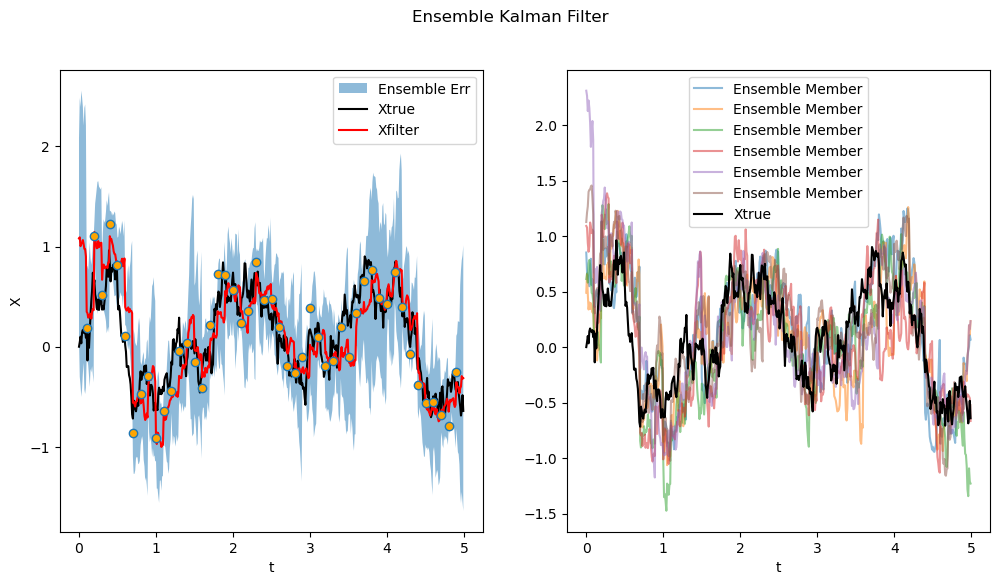

In [5]:
# this cell runs the ensemble filter 

# number of ensemble members 
E=6

# setting up some containers and initialize them 
Xfilter = np.zeros([E,M])
Xfilter[:,0] = Xe[:,0] + 1*np.random.randn(E)
Pfilter = np.zeros([M])
Pfilter[0] = 1.

# counter for the analysis samples
ns = 0

Hobs=np.eye(1)

for i in range(1,M):

    # update the forecast 
    Xforecast = stepEnsemble(Xfilter[:,i-1])

    Xanom = Xforecast-Xforecast.mean(axis=0)

    # get the forecast covariance
    Pforecast = np.dot(Xanom,Xanom.T)

    # do the analysis stage if its time 
    if ns == nsample-1:

        # part of the kalman gain that we will have to invert
        S = np.dot( np.dot(Hobs, Pforecast), Hobs.T) + R*np.eye(nobs)
        # kalman gain matrix     
        K = np.dot( Pforecast, np.dot( Hobs.T, la.inv(S) ) )

        for j in range(0,E):
            # obs innovation
            y = Zobs[0,i]+R*np.random.randn(nobs)- np.dot(Hobs,Xforecast[j])
            # do analysis 
            Xfilter[j,i] = Xforecast[j] + np.dot(K,y)

        # calculate the analysis covariance
        Xanom = Xfilter[:,i]-Xfilter[:,i].mean(axis=0)
        Pfilter[i] = np.dot(Xanom,Xanom.T)

        # restart the counter
        ns = 0

    # if its not time for an analysis update with the forecast values.
    else:
        
        Xfilter[:,i] = Xforecast 
        Pfilter[i] = Pforecast

        # update the counter 
        ns+=1


fig,axs=plt.subplots(1,2,figsize=(12,6))

axs[0].fill_between(x=t,
                    y1=Xfilter.mean(axis=0)+np.sqrt(Pfilter),
                    y2=Xfilter.mean(axis=0)-np.sqrt(Pfilter),
                    alpha=0.5,
                    label='Ensemble Err')
axs[0].plot(t,Xtrue,'k',
    label='Xtrue')
axs[0].plot(t,Xfilter.mean(axis=0),'r',label='Xfilter')
axs[0].legend()
axs[0].set_ylabel('X')
axs[0].set_xlabel('t')
axs[0].plot(t[nsample::nsample],Zobs[0][nsample::nsample],
            'o',markerfacecolor='orange',
            label='observations')

axs[1].plot(t,Xfilter.T,alpha=0.5,label='Ensemble Member')
axs[1].plot(t,Xtrue,'k',label='Xtrue')
axs[1].legend()
axs[1].set_xlabel('t')

plt.suptitle('Ensemble Kalman Filter')


# 5.4 - 4 dimensional variational analysis (4DVAR)

There are a couple of different references on 4D-VAR, but one that I found easy to follow was this one:
- Bannister, Ross N. "Elementary 4d-var." DARC Technical Report No. 2. Reading: University of Reading (2001).
  
The derivation of the 4DVAR costfunction is something that I greatly simplified from:
- Lorenc, Andrew C. "Analysis methods for numerical weather prediction." Quarterly Journal of the Royal Meteorological Society 112.474 (1986): 1177-1194.

## The basic idea 

- When we derived the least squares solution, we chose an objective function, and then we could analytically derive the parameter estimates. 
- The idea with 4DVAR is to define an objective function, which we will then optimize. Unlike with least squares it will not be possible to do this most of the time, but we numerically optimize the objective function to find some parameters
- Suppose that our observations, $\vec{z}(t)$, are coming over some initial period $t_i=t_0,...,t_n$ that happen before the forecast starts. We would like to pick an initial condition, $\vec{x}_0$, which minimizes our objective function. Jumping ahead a little bit, the final objective function is: $$\begin{align*}J\left(\vec{x}_0\right) = &  + \frac{1}{2} \sum_{k=1}^{k=n} \left(\vec{z}_k - H \vec{x}_k^f\right)^T \Gamma_r^{-1} \left(\vec{z}_k - H \vec{x}_k^f\right) \\ & \frac{1}{2} \left(\vec{x}_0 - \vec{x}^f\right)^T \Gamma_b^{-1}  \left(\vec{x}_0 - \vec{x}_f\right) \end{align*}  $$ 
  - $\Gamma_b$ is the uncertainty in the initial conditions 
  - $\Gamma_r$ is the uncertainty in the observations 
  - $H$ is the observation operator 
  
- In the next section I will give a short example showing how the numerical optimization of a cost function works, then we will derive $J$, and then finally discuss some practical challenges when using 4DVAR. 

## An analogy: Shooting Methods

- Imagine that you have a cannon, and you want to hit a distant target. We know the initial position of the cannon ball (where the cannon is) and the final position of the cannon ball (where the target). However to calculate the trajectory of the cannon ball what we actually need is the initial position of the cannon ball and the initial velocity of the cannon ball. What we need to do is to convert our knowledge of one initial and final positions into knowledge of the both the initial conditions.
  - Shooting methods are named this way because of this example. This type of problem is known as a boundary value problem, and they are very common.
- Mathematically this can be written as $$ \begin{align} \frac{d\vec{x}}{dt}  & = &  \vec{v}  \\
  \frac{d\vec{v}}{dt}  & = &  \vec{f}  \\ \end{align} $$
  - if we knew $\vec{x}_0$ and $\vec{v}_0$ we could solve for $\vec{x}(t)$. 
- The idea for a shooting method is that we define an objective function: $$ J(v) = \left(X_{final}(v) - X_{target}\right)^2 $$
- Then we make a guess about what $v$ is, evaluate the final position of our cannon ball, calculate $J$, and use this to update what our guess of $v$ is. By repeating this procedure several times we can find a value of $v$ that minimizes $J$
- This is essentially the same as 4DVAR, but the objective function is much more complicated. The core idea is the same though, we take an initial guess, calculate an objective function, use this to correct our guess, and the iterate until we can get a good estimate of our parameter. 
  

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# shooting method example

# this example calculates what velcotiy to fire a cannon to hit a target at targetDistance
# assuming that the cannon is angled at 45 degrees. 
# its pretty simple to solve the problem analytically, 
# this examples how the numerical solution works in python. 

def solveCannonBallPosition(v,dt=0.001):
    x,y = 0,0
    vx,vy = v*np.cos(45*np.pi/180),v*np.sin(45*np.pi/180)
    t=0
    fy = -9.8
    fx = 0.0
    while y >= 0:
        x = x + vx * dt
        y = y + vy * dt
        vy = vy + fy * dt 
        vx = vx + fx * dt
    return x 

def objectiveFunction(v,xObserved):
    xForecast =  solveCannonBallPosition(v)
    print(f'v: {v}, x: {xForecast}')
    return (xObserved-xForecast)**2

targetDistance = 2000
soln=fsolve(func=objectiveFunction,
           x0=200,
           args=(targetDistance,),
           full_output=True)

print('final v value:', soln[0][0])
print('number of iterations: ', soln[1]['nfev'])

v: [200], x: [4081.84460508]
v: [200.], x: [4081.84460508]
v: [200.], x: [4081.84460508]
v: [200.00000298], x: [4081.8446659]
v: [148.99689589], x: [2265.48545245]
v: [148.15375106], x: [2239.88472158]
v: [144.40362917], x: [2127.94708796]
v: [142.91261836], x: [2084.24868215]
v: [141.77130551], x: [2051.06285774]
v: [141.10858945], x: [2031.99608648]
v: [140.68018137], x: [2019.65940532]
v: [140.4203548], x: [2012.15613093]
v: [140.25951844], x: [2007.57031881]
v: [140.15762473], x: [2004.62529199]
v: [140.09693253], x: [2002.96472484]
v: [140.05460699], x: [2001.66636204]
v: [140.0350608], x: [2001.18896752]
v: [140.01479011], x: [2000.60227041]
v: [140.00779355], x: [2000.4032996]
v: [140.00210583], x: [2000.22303815]
v: [139.99959981], x: [2000.0882397]
v: [139.99913478], x: [2000.08159611]
v: [139.99639076], x: [2000.04239398]
v: [139.99537615], x: [2000.02789887]
v: [139.99460108], x: [2000.01682595]
v: [139.99415799], x: [2000.01049585]
v: [139.99387576], x: [2000.0064638]
v: [1

## Deriving the 4DVAR objective function 

- The derivation is somewhat similar to that for optimal interpolation, in that we are going to try to find the probability distribution of the model state conditioned on having some set of observations. 
- We are going to assume that everything is Gaussian. 
- I tried a few different notations, all of them are confusing, but this one is the least confusing:
  - $X_k \rightarrow$ matrix of all the model states as column vectors from time 0 to time k. 
  - $x_k \rightarrow$ vector of the model state at time k.   
  - $Z_k \rightarrow$ matrix of all the observations states as column vectors from time 0 to time k. 
  - $z_k \rightarrow$ vector of the observations at time k.   
- 
- Using Baye's thereom we can find that: $$ P\left(X_k|Z_k\right) \propto P\left(Z_k|X_k\right) P\left(X_k\right) $$

- If we assume that the observation noise is independently drawn at each time step, then we can expand using Baye's theorem to get:
$$ P\left(Z_k|X_k\right) = P\left(z_k|x_k\right)P\left(z_{k-1}|x_{k-1}\right)\dots P\left(z_{0}|x_{0}\right) $$

- If we assume that the model is Markovian, so that each time step only depends on the time step that came immediately before it, then we can expand the second probability using Baye's theorem to get:
$$ P\left(X_k\right) = P\left(x_{k}|x_{k-1}\right) P\left(x_{k-1}|x_{k-2}\right) \dots P\left(x_{0}\right) $$

- Now we have 3 different types of probabilities: $P\left(z_k|x_k\right), P\left(x_{k}|x_{k-1}\right), \mathrm{and}\; P\left(x_{0}\right)$ We can treat them seperately, but we will assume that all of them are multivariate Gaussians. We're also going to ignore a bunch of normalization factors, on the basis that they will work out in the end.
  - Using the observation model we can write: $$ \begin{align*} P\left(z_{k}|x_{k}\right)  \propto & \exp\left( - J^{obs}_{k} \right) \\ J^{obs}_{k}  = & \frac{1}{2}\left(\vec{z}_k - H \vec{x}_k\right)^T \Gamma_r^{-1} \left(\vec{z}_k - H \vec{x}_k\right) \end{align*} $$ Here $\Gamma_r$ is characterising the observation noise.
  - Using the forecast model we can write: $$ \begin{align*} P\left(x_{k}|x_{k-1}\right)  \propto & \exp\left( - J^{mod}_{k} \right) \\ J^{mod}_{k}  = & \frac{1}{2}\left(\vec{x}_k - F(\vec{x}_{k-1})\right)^T \Gamma_m \left(\vec{x}_k - F(\vec{x}_{k-1})\right) \end{align*} $$ For non-stochastic models the including the this term is equivalent to assuming that there is some model error that can be represented at each time step as a random perturbation. $\Gamma_m$ is thus characterizing the size of the model errors. 
  - And lastly, we can write $$  \begin{align*} P\left(x_{0}\right) \propto & \exp\left( - J^{ini} \right) \\ J^{ini}  = & \frac{1}{2}\left(\vec{x}^{b}_0 - \vec{x}_0\right)^T \Gamma_b \left(\vec{x}^{b}_0 - \vec{x}_0\right) \end{align*} $$ Here $\vec{x}_0$ is a vector of the initial conditions, and $\vec{x}^b$ is the background estimate. Ideally, $\Gamma_b$ would characterize the difference between the truth and the background. However in real applications the truth is never known approximatley, and so $\Gamma_B$ has to be approximated.

- We now put these pieces back together in a formulation know as "weak constraint 4DVAR":
$$ \begin{align*} P\left(Z_k|X_k\right) \propto & \exp\left(-J^{weak}\left(\vec{x}_0\right)\right) \\ 
J^{weak}\left(\vec{x}_0\right)  = & \frac{1}{2} \left[ \sum_{k=1}^{k=n}J^{obs}_{k} + \sum_{k=1}^{k=n}J^{mod}_{k} + J^{ini}\right] \\
% = &  + \frac{1}{2} \sum_{k=1}^{k=n} \left(\vec{z}_k - H \vec{x}_k^f\right)^T \left(R\right)^{-1} \left(\vec{z}_k - H \vec{x}_k^f\right) \\
% & \frac{1}{2} \sum_{k=1}^{k=n} \left(\vec{x}_k - F(\vec{x}_{k-1})\right)^T \left(B\right)^{-1} \left(\vec{x}_k - F(\vec{x}_{k-1})\right) \\
%  & \frac{1}{2} \left(\vec{x}_0 - \vec{x}^f\right)^T \left(P_0^f\right)^{-1}  \left(\vec{x}_0 - \vec{x}_f\right)  & 
 \end{align*} $$

- Note that even though $\vec{x}_0$ only appears explicitly in $ J^{ini}$, implicitly it is in included in $J^{mod}$ and $J^{obs}$, since both of those depend on $\vec{x}_k$, which depends on $\vec{x}_0$.

- Since $P\left(Z_k|X_k\right)$ is maximized when $J^{weak}$ is a minnimum, the 4DVAR algorithm amounts to choosing $\vec{x}_0$ in to minnimize $J^{weak}$. Conceptually 4DVAR is pretty straightforward now:
  1. choose an initial guess of $\vec{x}_0$ and calculate $J$
  2. choose another guess of $\vec{x}_0$ and calculate $J$
  3. use these two values to estimate $\nabla_{\vec{x}_0} J$
  4. use $\nabla_{\vec{x}_0} J$ to pick another value of $x_0$ and calculate $J$
  5. continue until $J$ reaches a minimum 

- Most of the time estimating $\Gamma_m$ is not feasible. This leads to the more popular "perfect model" or "Strong Constraint" 4DVAR by removing the model error term: $$ J^{strong}\left(\vec{x}_0\right)  =  \frac{1}{2} \left[ \sum_{k=1}^{k=n}J^{obs}_{k} + J^{ini}\right] $$ Usually when people refer to 4DVAR they mean the strong constraint 4DVAR
  - substituting in all the expressions into this gives the expression that I quoted at the start of this subsection. 

- What would happen if we only had observations at one time point, say time $k$? Then we would have 3DVAR: $$ J^{3D}\left(\vec{x}_0\right)  = \frac{1}{2} \left[ J^{obs}_{k} + J^{ini}\right] $$ 
  - 3DVAR was a popular algorithm until it was replaced by 4DVAR. Conceptually though its the same thing. 

## Practically implementing 4DVAR and adjoint models

- Ok so before I said you just need to minimize $J$ and you're done. In practice this is really difficult, because in order to minimize $J$ you need to calculate the gradient of $J$ with respect to the initial conditions variables, e.g. $$ \frac{\partial J}{\partial_{\vec{x}_0}}  = \begin{pmatrix} \frac{\partial J}{\partial_{x^1}} \\ \frac{\partial J}{\partial_{x^2}} \\ \vdots \end{pmatrix} $$

- Suppose that we wanted to compute this numerically. We could run the model once by setting ${x^1_{0}}' =  x^1_0 + \delta x$, and then repeating for all the difference dimensions so that we get  $$ \frac{\partial J}{\partial_{\vec{x}_0}}  \approx \begin{pmatrix} \frac{J({x^1_{0}}')-J{x^1_{0}}}{{x^1_{0}}' - {x^1_{0}}} \\ \frac{J({x^2_{0}}')-J{x^2_{0}}}{{x^2_{0}}' - {x^2_{0}}} \\ \vdots \end{pmatrix} $$

- This might not look too bad so far but there are two problems:
  1. the variations are in $\vec{x_0}$. If the observations are not taken until some point $\vec{x}_k$ far into the future, then every time we need to evaluate $J$ we have to do a very long model run first.
  2. the dimension of $x$ can be very large.

-  So for a small number of dimensions and a not very complicated model thats ok, and with a couple slight variations is more or less what scipy.optimize is doing in most of its routines. However for a modern weather, climate, or ocean model this isn't feasible, since the dimension of x can easily be in the millions and running the model is very expensive computationally. We need a new way to evaluate the gradient that involves fewer model integrations somehow.

### Calculating the gradient using an adjoint model

- Lets assume that $\vec{x}_0$ is a true minimum. Then our guess for it initially will be the true guess plus a perturbation, which we assume to be small:  $$ J(\vec{x}_0+\delta \vec{x}_0) = J(\vec{x}_0) + \delta J $$

- $\delta J$ is called the variation of $J$ (hence the name 4DVAR), and it can found by taking a dot product between $\nabla_{\vec{x_0}} J$ and $\delta x_0$: $$ \begin{align*} \delta J = & \left[ \frac{\partial J}{\partial_{\vec{x}_0}}^T \delta \vec{x}_0 \right] \\
\end{align*} $$.
  - $\delta J$ is a scalar, like $J$.  

- Its easier if we think about summing over all the errors in time. We will assume that $\vec{x}_k$ are the actual optimal solutions, and $\delta \vec{x}_k$ are the perturbations to this, so that the variation can be written  $$ \begin{align*} \delta J = & \sum_{k=1}^{k=n} \left[ \frac{\partial J}{\partial_{\vec{x}_k}}^T \delta \vec{x}_k \right] \\
\end{align*} $$ 

- If we could convert the $\delta \vec{x}_k$ to be functions of $\delta \vec{x}_0$ somehow then the variation could be written as a matrix dotted with $\delta \vec{x}_0$. We can do this by linearizing the forecast model:

$$ \begin{align*} \delta x_{k+1} = & F\left(x_{k}+\delta_x\right) - F\left(x_{k}\right) \\ = & \frac{\partial F}{\partial \vec{x}_k} \delta \vec{x}_k \\
= & \left(\frac{\partial F}{\partial \vec{x}}_{k} \cdots \frac{\partial F}{\partial \vec{x}_0} \right) \delta\vec{x}_0   \\
% = & M_k \delta\vec{x}_0   
\end{align*}  $$ 

- $\frac{\partial F}{\partial \vec{x}}$ is called the tangent linear model. 

- The next step is to use the tangent linear model to write $\delta J$ in terms of $\delta \vec{x}_0$. This is easier if we use the following 2 matrix identities involving transposes:
  - $A^TB^T = (BA)^T$
  - $A^T\left(Bx\right)=A^T\left(B^{TT}x\right)=\left(A^TB^{TT}\right)x=\left(B^TA\right)^Tx$

- We can substitute our expressions for $\vec{x}_{k}$ into the expression for the variation in $J$ and use these transpose identities to get: 

$$ \begin{align*} \delta J = & \sum_{k=1}^{k=n} \left[  \frac{\partial J}{\partial_{\vec{x}_k}}^T \left(\frac{\partial F}{\partial \vec{x}}_{k} \cdots \frac{\partial F}{\partial \vec{x}_0} \right) \delta\vec{x}_0 \right] \\

= & \sum_{k=1}^{k=n} \left[  \frac{\partial J}{\partial_{\vec{x}_k}}^T \left(\frac{\partial F}{\partial \vec{x}}_{k} \cdots \frac{\partial F}{\partial \vec{x}_0} \right)^{TT} \delta\vec{x}_0 \right]\\

 = & \left[ \sum_{k=1}^{k=n}  \left( \left( \frac{\partial F}{\partial \vec{x}}_{k} \cdots \frac{\partial F}{\partial \vec{x}_0} \right)^T \frac{\partial J}{\partial_{\vec{x}_k}} \right)^T \right] \delta\vec{x}_0\\

 = & \left[ \sum_{k=1}^{k=n}   \left( \frac{\partial F}{\partial \vec{x}}_{0}^T \cdots \frac{\partial F}{\partial \vec{x}_k}^T  \frac{\partial J}{\partial_{\vec{x}_k}}  \right) ^T \right] \delta\vec{x}_0\\

\end{align*} $$

- And so finally comparing with our original expression we find that $$\frac{\partial J}{\partial_{\vec{x}_0}} =  \frac{\partial F}{\partial \vec{x}}_{0}^T \cdots \frac{\partial F}{\partial \vec{x}_k}^T  \frac{\partial J}{\partial_{\vec{x}_k}} $$

- $\frac{\partial F}{\partial \vec{x}}^T$ is called the adjoint model. Essentially the adjoint model integrates backwards in time, allowing us to relate the impacts of an observation at some point in the model run to the initial conditions that the run started with. 
  - Without using adjoint models 4DVAR is basically impossible to implement in most cases. 
  - However in general adjoint models have to be written separately from the main code, either by hand or by the use of automatic adjoint algorithms which try to automatically generate adjoint code. In either case, while its computationally efficient it represents a large commitment in terms of human time. This was the largest barrier to using 4DVAR for some time.

- We're not going to worry too much about tangent linear or adjoint models in this course, writing them is a little bit tricky the first time that you try them and the models that we are implementing are simple enough that you don't really need to use them. Still its important that you know what they are so that you understand why 4DVAR can be instantly implemented in any model and you will know whats happening when people talk about them.

- It turns out that evaluating the sum can also be optimized, the trick to doing this is in Bannister (2001), but it turns $n^2/2$ applications of the adjoint into $n$ applications, which also greatly improves evaluating the operator. After this, evaluating the gradient once becomes equivalent to taking $n$ forward timesteps of the forecast followed by $n$ backward timesteps using the adjoint model. 
  
- For quadraditic non-linearities common in fluid dynamics the adjoint model will be twice as expensive as the forecast model, so doing 1 iteration is approximately the same cost as 3 ensemble members.   

## 4DVAR Example

- Doing 4D var with the example that I picked is not ideal. The reason is that the model forgets the different initial conditions that it after time length $\tau$.
- Instead what we would really like to do is to treat the $w_k$ like control parameters, and choose them in a way that optimizes our solution against the observations.
  - Unfortunately we can't choose as many $w_k$ as there are time steps, so we will average them over each forecast interval and just hold them constant. This is essentially the same thing as estimating a low pass filtered version of $w$  
- This is actually how the ECCO ocean model reanalysis works, by choosing control parameters in order to optimize the model state against a set of observations.
- For our case we can formulate a new cost function: $$ J = \frac{1}{2} \left( \frac{1}{\Gamma_b} \sum_k^{n} w_k^2 + \frac{1}{\Gamma_r}\sum_{k}^n \left(z - x_k(w_k)\right)^2 \right) $$ Where I have assumed that the background is 0, the obs operator is just the identity matrix, and used the fact that this is a scalar example to write the inverse matrices as division. 
- In the lab we will do a more traditional version of 4DVAR where we optimize an initial condition.   

Text(0.5, 0.98, '4DVAR')

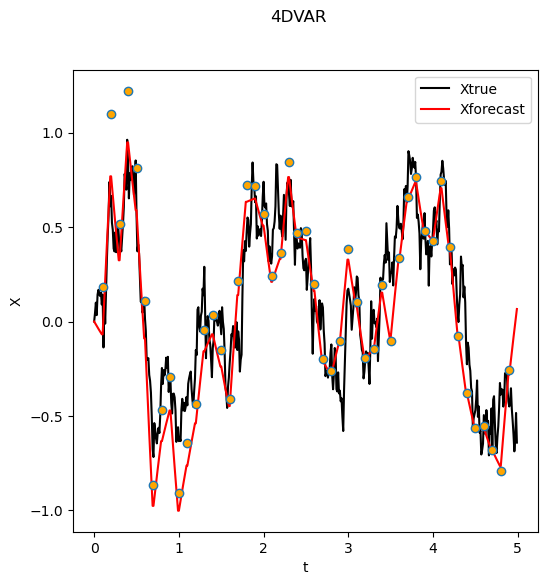

In [7]:
# this function forecasts the 1DOU process ahead assuming a constant value of W
def generate_xf(x0,wc,nsample):

    xf=np.zeros(nsample)
    xf[0]=x0
    for i in range(1,nsample):
        xf[i] = xf[i-1]*np.exp(-dt/tau) + B * np.sqrt(dt) * wc
    return xf

# this calculates J
# because its a scalar I am a being a little loose with the matrix size 
def evalCostFunction(wc,xb,zobs,nsample,nobs,gammaB,gammaR):

    Xforecast=np.zeros(M)
    Jo = 0

    for i in range(0,nobs):
        # if not (Xforecast[i*nsample-1]==0):
        #     print(Xforecast[i*nsample])
        x0 = Xforecast[i*nsample-1]
#        print(x0)
        xf = generate_xf(x0,wc[i-1],nsample)
        Xforecast[i*nsample:(i+1)*nsample] = xf
        Jo += (zobs[i] - xf[-1])**2 / gammaR

    Jb =  (wc**2).sum() / gammaB

    # print(Jo,Jb)

    return 0.5*(Jo+Jb)

# this chooses wc in order to minnimize J
# then this uses these values of wc to calculate X
def forecast4DVAR(xb,zobs,nsample,nobs,gammaB,gammaR):

    Xforecast=np.zeros(M)

    results=opt.minimize(
        fun=evalCostFunction,
        x0=np.zeros(nobs),
        args=(xb,zobs,nsample,nobs,gammaB,gammaR),
#        options={'disp':True,
        #         'xrtol':1e-5,
#                },
        # method='BFGS'
    )

    wc = results.x

    for i in range(0,nobs):
        xf = generate_xf(Xforecast[i*nsample-1],wc[i],nsample)
        Xforecast[i*nsample:(i+1)*nsample] = xf

    return Xforecast

z = Zobs[0,0::nsample]
Xforecast = forecast4DVAR(0,z,nsample,len(z),gammaB,gammaR)

fig,axs=plt.subplots(1,1,figsize=(6,6))

axs.plot(t,Xtrue,'k',
    label='Xtrue')
axs.plot(t,Xforecast,'r',label='Xforecast')
axs.legend()
axs.set_ylabel('X')
axs.set_xlabel('t')
axs.plot(t[nsample::nsample],Zobs[0][nsample::nsample],
            'o',markerfacecolor='orange',
            label='observations')

fig.suptitle('4DVAR')